# ISLP - Chapter 4 - Exercise 16
### Author: pzuehlke

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

We begin by loading the dataset and resetting the index column (originally, `Unnamed: 0`).

In [66]:
housing = pd.read_csv("Boston.csv")
housing = housing.dropna()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   crim        506 non-null    float64
 2   zn          506 non-null    float64
 3   indus       506 non-null    float64
 4   chas        506 non-null    int64  
 5   nox         506 non-null    float64
 6   rm          506 non-null    float64
 7   age         506 non-null    float64
 8   dis         506 non-null    float64
 9   rad         506 non-null    int64  
 10  tax         506 non-null    int64  
 11  ptratio     506 non-null    float64
 12  lstat       506 non-null    float64
 13  medv        506 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 55.5 KB


In [67]:
housing.rename(columns={"Unnamed: 0": "index"}, inplace=True)
housing.set_index("index", inplace=True)
housing.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
index,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


Now let's create the response as described in the statement:

In [68]:
crime_median = housing["crim"].median()
housing["high_crime"] = (housing["crim"] > crime_median).astype(int)
print(housing["high_crime"].sum())
housing.head()

253


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,high_crime
index,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,0
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,0
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,0


We see that out of a total of $ 506 $ entries, exactly half have been labeled as
having a high crime rate, meaning above the median, as expected. Let's construct
boxplots of crime rates by high-crime classification:

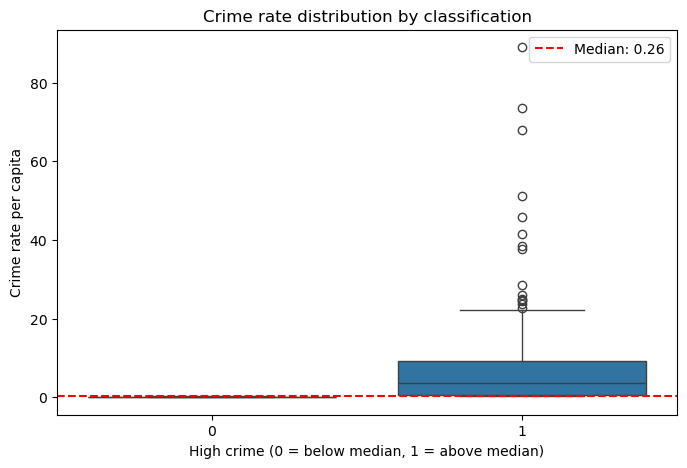

In [69]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=housing, x="high_crime", y="crim", ax=ax)
ax.set_title("Crime rate distribution by classification")
ax.set_xlabel("High crime (0 = below median, 1 = above median)")
ax.set_ylabel("Crime rate per capita")
ax.axhline(y=crime_median, color="red", linestyle="--", label=f"Median: {crime_median:.2f}")
ax.legend()
plt.show()

We now define a function (recycled from exercise 14) to conveniently evaluate
the performance of the various models that we will fit to the data:

In [98]:
def evaluate_model(y_true, y_predicted, model_name):
    accuracy = accuracy_score(y_true, y_predicted)
    error_rate = 1 - accuracy
    conf_matrix = confusion_matrix(y_true, y_predicted)

    print(f"\n{model_name} results:")
    print("=" * (len(model_name) + len(" results:")))
    print(f"\nTest accuracy: {accuracy:.4f}")
    print(f"Test error rate: {error_rate:.4f}")
    
    print(f"\nClassification report:")
    print(classification_report(y_true, y_predicted))

    cm = pd.DataFrame(conf_matrix)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["low crime", "high crime"],
                yticklabels=["low crime", "high crime"],
                cbar=False,
                ax=ax)
    ax.set_xlabel("predicted")
    ax.set_ylabel("actual")
    ax.set_title(f"Confusion matrix - {model_name}")
    plt.show()
    
    return error_rate

Our strategy will be as follows. We begin by splitting the data into training
and test sets. Then we fit a _linear_ regression model with response the crime
rate `crim` (not the qualitative variable `high_crime`) using every other
variable as a predictor. For this we use `statsmodels` so that we can access its
`summary` method and the associated $ p $-values. Based on these $ p $-values,
we will decide which variables will be kept to fit all the other models.

In [80]:
X = housing.drop(["crim", "high_crime"], axis=1)
y = housing["crim"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [81]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [82]:
X_with_const = sm.add_constant(X_train_scaled)
lin_reg_model = sm.OLS(y_train, X_with_const).fit()
print(lin_reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     21.89
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.09e-35
Time:                        15:18:46   Log-Likelihood:                -1152.1
No. Observations:                 354   AIC:                             2330.
Df Residuals:                     341   BIC:                             2381.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3583      0.340      9.892      0.0

Using a $ 5\% $ threshold for the $ p $-value, the only predictors that appear
to be statistically significant in predicting crime rate are `dis`, `rad`,
`lstat` and `medv`.  Thus, we will remove the remaining variables from
consideration when building our models. From now on we use `sklearn` for
the sake of uniformity. We need to reset our feature matrix and response
variable.

In [83]:
X = housing[["dis", "rad", "lstat", "medv"]]
y = housing["high_crime"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Our first model uses logistic regression:


logistic regression results:

Test accuracy: 0.8824
Test error rate: 0.1176

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89        51
           1       0.91      0.84      0.88        51

    accuracy                           0.88       102
   macro avg       0.88      0.88      0.88       102
weighted avg       0.88      0.88      0.88       102



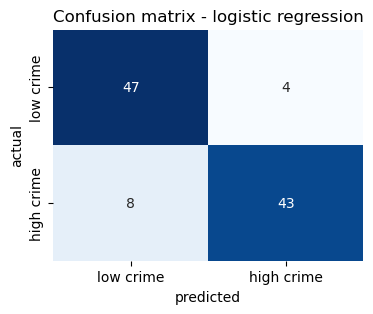

In [119]:
lr = LogisticRegression()
log_reg_model = lr.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg_model.predict(X_test_scaled)
log_reg_error_rate = evaluate_model(y_test, log_reg_predictions, "logistic regression")

The error rate of $ 11.8\% $ looks good. Let's see if we can improve it using another model.


LDA results:

Test accuracy: 0.8627
Test error rate: 0.1373

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        51
           1       0.91      0.80      0.85        51

    accuracy                           0.86       102
   macro avg       0.87      0.86      0.86       102
weighted avg       0.87      0.86      0.86       102



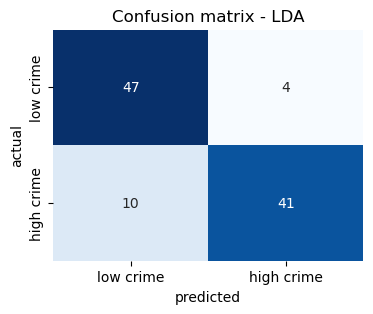

In [101]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train_scaled, y_train)
lda_predictions = lda_model.predict(X_test_scaled)
lda_error_rate = evaluate_model(y_test, lda_predictions, "LDA")

Unfortunately, the error rate has increased to $ 13.7\% $. Let's try QDA next:


QDA results:

Test accuracy: 0.8333
Test error rate: 0.1667

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        51
           1       0.95      0.71      0.81        51

    accuracy                           0.83       102
   macro avg       0.86      0.83      0.83       102
weighted avg       0.86      0.83      0.83       102



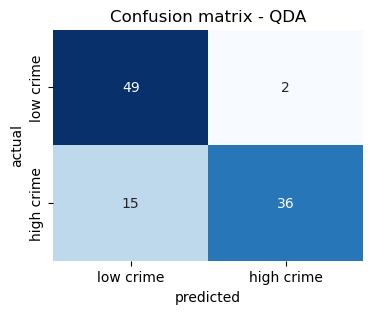

In [102]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_scaled, y_train)
qda_predictions = qda_model.predict(X_test_scaled)
qda_error_rate = evaluate_model(y_test, qda_predictions, "QDA")

This has an even worse error rate of $ 16.7\% $.


naive Bayes results:

Test accuracy: 0.8137
Test error rate: 0.1863

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        51
           1       0.92      0.69      0.79        51

    accuracy                           0.81       102
   macro avg       0.84      0.81      0.81       102
weighted avg       0.84      0.81      0.81       102



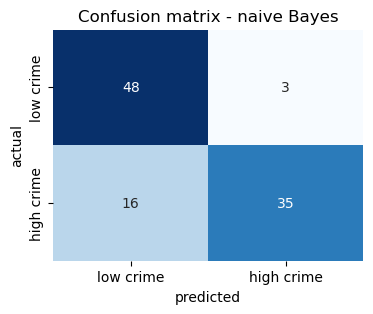

In [120]:
nb = GaussianNB()
nb_model = nb.fit(X_train_scaled, y_train)
nb_predictions = nb_model.predict(X_test_scaled)
error_rate = evaluate_model(y_test, nb_predictions, "naive Bayes")

Again, the error rate is poorer than those of previous models. Finally, let's
try KNN for several values of $ K $.

In [110]:
ks = range(1, 21)
knn_errors = []
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    knn_predictions = knn_model.predict(X_test_scaled)
    error = 1 - accuracy_score(y_test, knn_predictions)
    knn_errors.append(error)

best_k_index = np.argmin(knn_errors)
best_k = ks[best_k_index]
best_knn_error = knn_errors[best_k_index]
print(f"The best value of K on the test data is K = {best_k}.")

The best value of K on the test data is K = 5.


Let's plot the error rates for all values of $ K $ from $ 1 $ to $ 20 $ for comparison:

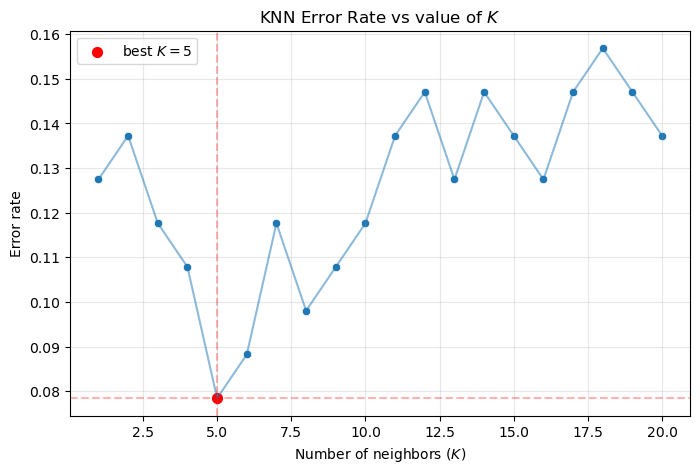

In [ ]:
error_df = pd.DataFrame({ "K": ks, "error rate": knn_errors})
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=error_df, x="K", y="error rate", ax=ax)
sns.lineplot(data=error_df, x="K", y="error rate", ax=ax, alpha=0.5)

ax.scatter(best_k, best_knn_error, color="red", s=50, label=f"best $ K = {best_k} $")
ax.set_title("KNN Error Rate vs value of $ K $")
ax.set_xlabel("Number of neighbors ($ K $)")
ax.set_ylabel("Error rate")
ax.grid(True, alpha=0.3)
ax.legend()

ax.axvline(x=best_k, color="red", linestyle="--", alpha=0.3)
ax.axhline(y=best_knn_error, color="red", linestyle="--", alpha=0.3)

plt.show()

Note how the resulting curve is approximately $ U $-shaped. Finally, we
summarize the relevant scores obtained for the best value of $ K $.


KNN (K = 5) results:

Test accuracy: 0.9216
Test error rate: 0.0784

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        51
           1       0.92      0.92      0.92        51

    accuracy                           0.92       102
   macro avg       0.92      0.92      0.92       102
weighted avg       0.92      0.92      0.92       102



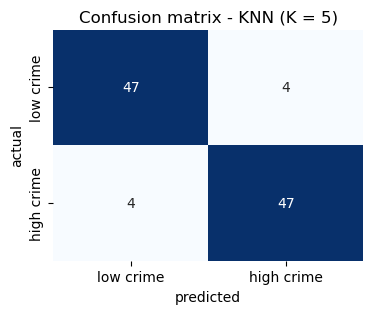

0.07843137254901966

In [117]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
y_pred_best_knn = best_knn.predict(X_test_scaled)
evaluate_model(y_test, y_pred_best_knn, f"KNN (K = {best_k})")

This error rate for KNN-$ 5 $ of $ 7.84\% $ is the best one achieved by any of
the models we tried. In a real setup we would now refit this model using the entire
training data.